In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Input, Dense
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dense
import keras_nlp

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import copy
warnings.simplefilter(action='ignore')

In [5]:
data = pd.read_csv('u.data', sep='\t', names=['user_id', 'movie_id', 'rating', 'timestamp'])

In [6]:
# Load the MovieLens 100K dataset
# Assuming the file is 'u.data' in the same directory
# Columns: user_id, movie_id, rating, timestamp
data = pd.read_csv('u.data', sep='\t', names=['user_id', 'movie_id', 'rating', 'timestamp'])
data['rating'] = data['rating'] - 2
data = data[data['rating'] > 0]

# Step 0: only select top 50 movies
valid_movies = np.array(data['movie_id'].value_counts().index[:50])
data = data[data['movie_id'].isin(valid_movies)]

# Step 1: Remove users s.t. count >= 2 * unique timestamp
temp = data.groupby('user_id')['timestamp'].agg(['count', 'nunique']).reset_index()
valid_users = temp[temp['count']/temp['nunique'] < 2]['user_id']
data = data[data['user_id'].isin(valid_users)]

# Step 2: Remove users with only 1 rating
temp = data['user_id'].value_counts() 
one_rating = np.array(temp[temp == 1].index)
data = data[~data['user_id'].isin(one_rating)]

# Step 3: Deduplicate and recode
data = data.groupby(['user_id', 'timestamp'], group_keys=False).apply(lambda group: group.sample(n=1, random_state=42))
data = data.sort_values(['user_id', 'timestamp']).reset_index(drop = True)
data['movie_id'] = pd.factorize(data['movie_id'])[0] + 1

num_users = data['user_id'].nunique()
num_movies = data['movie_id'].nunique()
num_ratings = len(data)

sparsity = 1 - (num_ratings / (num_users * num_movies))

print(f"Filtered Dataset: {num_users} users, {num_movies} movies")
print(f"Sparsity: {sparsity:.2%}")

Filtered Dataset: 893 users, 50 movies
Sparsity: 72.08%


In [7]:
np.random.seed(42)

all_users = data['user_id'].unique()
shuffled_indices = np.random.permutation(len(all_users))

midpoint = 3 * len(all_users) // 4
indices_1 = shuffled_indices[:midpoint]
indices_2 = shuffled_indices[midpoint:]

train_users = shuffled_indices[indices_1]
test_users = shuffled_indices[indices_2]

In [8]:
data_train = data[data['user_id'].isin(train_users)].reset_index(drop = True)
data_test = data[data['user_id'].isin(test_users)].reset_index(drop = True)

In [9]:
data[data['user_id'] == 2]

,user_id,movie_id,rating,timestamp
29,2,30,2,888549960
30,2,29,1,888549961
31,2,31,1,888550252
32,2,23,2,888550774
33,2,4,2,888550871
34,2,32,3,888550939
35,2,33,2,888551062
36,2,34,2,888551552
37,2,35,2,888552017
38,2,36,3,888552084


In [10]:
def preprocess_data(df):
    
    center = []
    movie = []
    rating = []
    length = []
    target = []
    
    unique_user_ids = df['user_id'].unique()
    
    for user_id in unique_user_ids:

        temp = df[df['user_id'] == user_id]
        movie_list, rating_list = list(temp['movie_id']), list(temp['rating'])
        center += movie_list
        target += rating_list
        
        for idx in range(temp.shape[0]):
            movie.append(movie_list[:idx] + [0] * (temp.shape[0] - idx))
            rating.append(rating_list[:idx] + [0] * (temp.shape[0] - idx))
            length.append(idx if idx > 0 else 1)
            
    return center, movie, rating, length, target

In [11]:
center_train, movie_train, rating_train, length_train, target_train \
    = preprocess_data(data_train)

center_test, movie_test, rating_test, length_test, target_test \
    = preprocess_data(data_test)

In [12]:
center_train, center_val, movie_train, movie_val, rating_train, rating_val, \
length_train, length_val, target_train, target_val = train_test_split(
    center_train, movie_train, rating_train, length_train, target_train, 
    test_size=0.25, random_state=42
)

In [13]:
max_ctx = max(length_train + length_test + length_val)

In [14]:
movie_train = [movie + [0] * (max_ctx - len(movie)) if len(movie) < max_ctx 
               else movie[:max_ctx] for movie in movie_train]

movie_val = [movie + [0] * (max_ctx - len(movie)) if len(movie) < max_ctx 
               else movie[:max_ctx] for movie in movie_val]

movie_test = [movie + [0] * (max_ctx - len(movie)) if len(movie) < max_ctx 
               else movie[:max_ctx] for movie in movie_test]

rating_train = [rating + [0] * (max_ctx - len(rating)) if len(rating) < max_ctx 
               else rating[:max_ctx] for rating in rating_train]

rating_val = [rating + [0] * (max_ctx - len(rating)) if len(rating) < max_ctx 
               else rating[:max_ctx] for rating in rating_val]

rating_test = [rating + [0] * (max_ctx - len(rating)) if len(rating) < max_ctx 
               else rating[:max_ctx] for rating in rating_test]

In [15]:
center_train_data = np.array(center_train)  # Center movie
context_train_data = np.array(movie_train)  # Context movies
rating_train_data = np.array(rating_train)  # Context ratings
length_train_data = np.array(length_train)  # Length of the context
target_train_data = np.array(target_train)  # Target rating

center_val_data = np.array(center_val)  # Center movie
context_val_data = np.array(movie_val)  # Context movies
rating_val_data = np.array(rating_val)  # Context ratings
length_val_data = np.array(length_val)  # Length of the context
target_val_data = np.array(target_val)  # Target rating

center_test_data = np.array(center_test)  # Center movie
context_test_data = np.array(movie_test)  # Context movies
rating_test_data = np.array(rating_test)  # Context ratings
length_test_data = np.array(length_test)  # Length of the context
target_test_data = np.array(target_test)  # Target rating

In [16]:
embedding_size = 32
input_dim = data['movie_id'].nunique() + 1

center_input = layers.Input(shape=(1,), dtype=tf.int32, name="center_input")  
context_input = layers.Input(shape=(max_ctx,), dtype=tf.int32, name="context_input")  
rating_input = layers.Input(shape=(max_ctx,), dtype=tf.float32, name="rating_input")  
length_input = layers.Input(shape=(1,), dtype=tf.float32, name="length_input") 

movie_embedding = layers.Embedding(input_dim=input_dim, output_dim=embedding_size)(context_input)
center_embedding = layers.Embedding(input_dim=input_dim, output_dim=embedding_size)(center_input)

rating_input = layers.Reshape((max_ctx, 1))(rating_input)
weighted_embeddings = layers.Multiply()([movie_embedding, rating_input])

sum_embeddings = layers.Lambda(lambda x: tf.reduce_sum(x, axis=1), name="sum_embeddings")(weighted_embeddings)

average_embeddings = layers.Lambda(lambda inputs: inputs[0] / inputs[1], name="average_embeddings")(
    [sum_embeddings, length_input]
)

center_embedding_flat = layers.Flatten()(center_embedding)
lambda_output = layers.Dot(axes=-1, name="dot_product")([average_embeddings, center_embedding_flat])
lambda_output_exp = layers.Activation('exponential', name="lambda_output_exp")(lambda_output)

model = Model(inputs=[center_input, context_input, rating_input, length_input], outputs=lambda_output_exp)

#### score follows a Poisson distribution with mean 1 + exp(.)

def poisson_log_likelihood(y_true, y_pred):
    epsilon = 1e-8
    return tf.reduce_mean(1 + y_pred - y_true * tf.math.log(1 + y_pred))


model.compile(optimizer=Adam(learning_rate = 1e-4), loss=poisson_log_likelihood)

early_stopping = EarlyStopping(
    monitor='val_loss',    
    patience=10,  
    restore_best_weights=True 
)

# Fit the model with validation data and early stopping
history = model.fit(
    [center_train_data, context_train_data, rating_train_data, length_train_data], 
    target_train_data,        
    validation_data=([center_val_data, context_val_data, rating_val_data, length_val_data], target_val_data),  
    epochs=1000,                 
    batch_size=256,            
    callbacks=[early_stopping] 
)

Epoch 1/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.5277 - val_loss: 0.5328
Epoch 2/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5335 - val_loss: 0.5327
Epoch 3/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5362 - val_loss: 0.5326
Epoch 4/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5329 - val_loss: 0.5325
Epoch 5/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5371 - val_loss: 0.5324
Epoch 6/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5325 - val_loss: 0.5323
Epoch 7/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5333 - val_loss: 0.5321
Epoch 8/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5329 - val_loss: 0.5319
Epoch 9/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5298 - val_loss: 0.5317
Epoch 10/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5333 - val_loss: 0.5314
Epoch 11/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5360 - val_loss: 0.5310
Epoch 12/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

In [17]:
test_loss = model.evaluate([center_test_data, context_test_data, rating_test_data, length_test_data], target_test_data)
print(f"Test Loss: {test_loss}")

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 606us/step - loss: 0.4810
Test Loss: 0.5078315138816833


In [18]:
pred_test_ratings = model.predict([center_test_data, context_test_data, rating_test_data, length_test_data]).flatten()

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


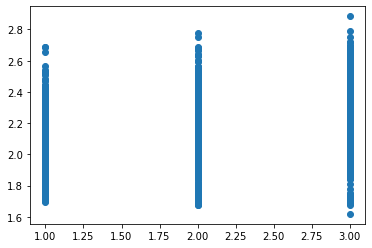

In [19]:
plt.scatter(target_test_data, pred_test_ratings + 1);

In [20]:
(pred_test_ratings + 1)[target_test_data == 1].mean(), \
    (pred_test_ratings + 1)[target_test_data == 2].mean(), \
        (pred_test_ratings + 1)[target_test_data == 3].mean()

(2.061231, 2.0958197, 2.2031686)

In [21]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ context_input       │ (None, 43)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 43, 32)    │      1,632 │ context_input[1]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_2CLONE │ (None, 43, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 43, 32)    │          0 │ embedding[1][0],  │
│                     │                   │            │ keras_tensor_2CL… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ center_input        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sum_embeddings      │ (None, 32)        │          0 │ multiply[1][0]    │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ length_input        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 32)     │      1,632 │ center_input[1][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_embeddings  │ (None, 32)        │          0 │ sum_embeddings[1… │
│ (Lambda)            │                   │            │ length_input[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 32)        │          0 │ embedding_1[1][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1)         │          0 │ average_embeddin… │
│                     │                   │            │ flatten[1][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_output_exp   │ (None, 1)         │          0 │ dot_product[1][0] │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,794 (38.26 KB)

 Trainable params: 3,264 (12.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,530 (25.51 KB)